In [11]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error
path = "Results/energy_train_m/energy_ip_336_op_50_whole_in_test/energy/"
preds = np.load(path+'trans-mse-ar_pred_mu.npy')
inputs = np.load(path+'inputs.npy')
trues = np.load(path+'targets.npy')
#preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])
#trues = trues.reshape(-1, preds.shape[-2], preds.shape[-1])
# [samples, pred_len, dimensions]
print(preds.shape, trues.shape, inputs.shape)

print("mse : ",mean_squared_error(trues.squeeze(),preds.squeeze()),"mae: ",mean_absolute_error(trues.squeeze(),preds.squeeze()))

(161, 50, 1) (161, 50, 1) (161, 336, 1)
mse :  9491.406 mae:  48.164318


In [9]:
# x = preds.reshape(54,13,-1,1)
# preds = x.mean(axis=1)
# preds.shape
# x = trues.reshape(54,13,-1,1)
# trues = x.mean(axis=1)
# trues.shape

# print("mse : ",mean_squared_error(trues.squeeze(),preds.squeeze()),"mae: ",mean_absolute_error(trues.squeeze(),preds.squeeze()))

<ipython-input-12-d69f9c5b992a>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


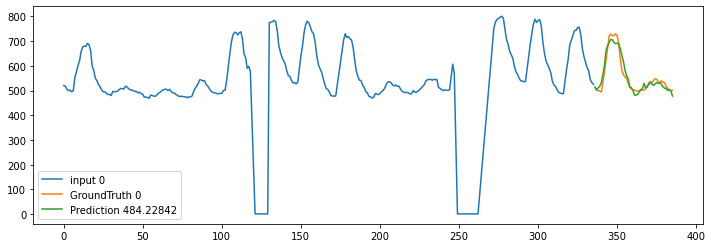

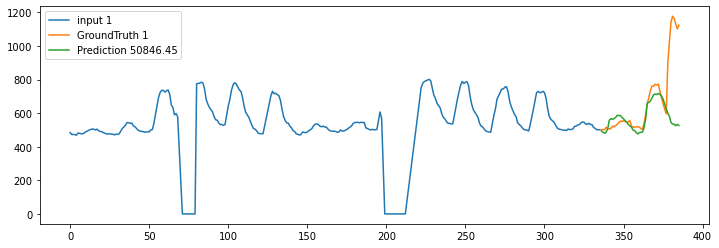

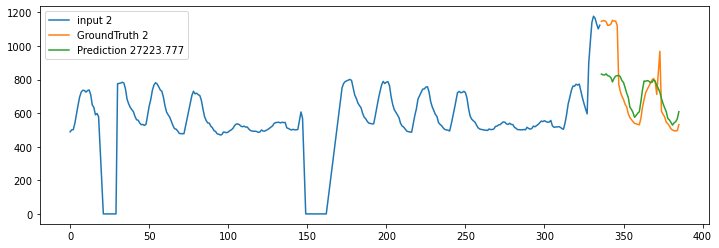

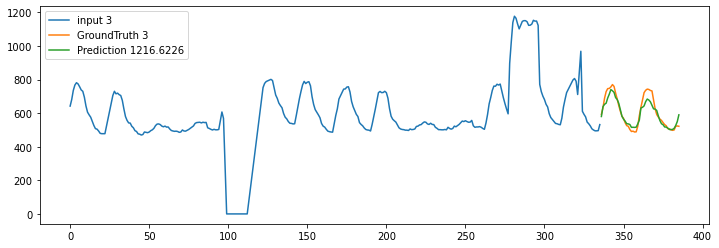

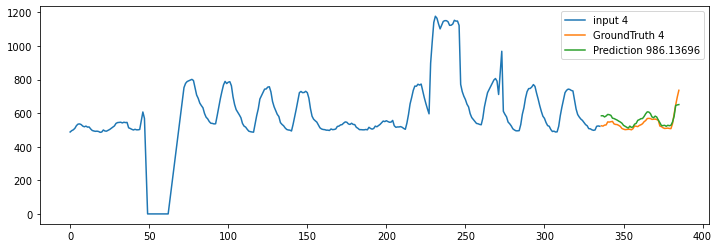

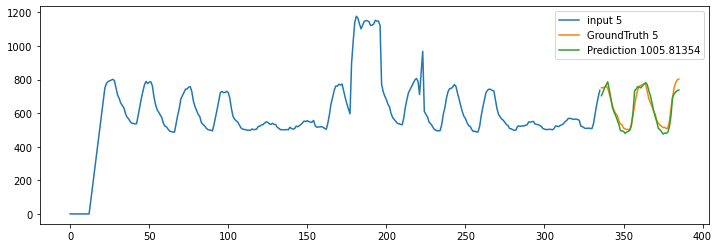

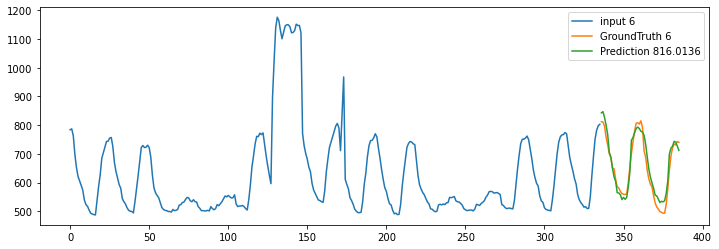

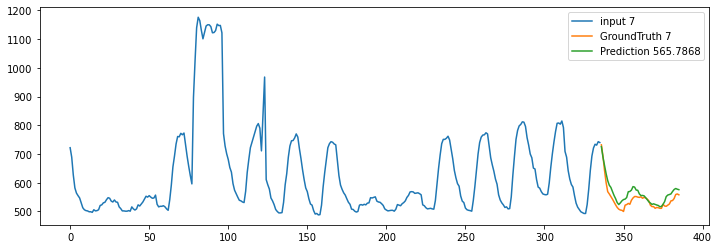

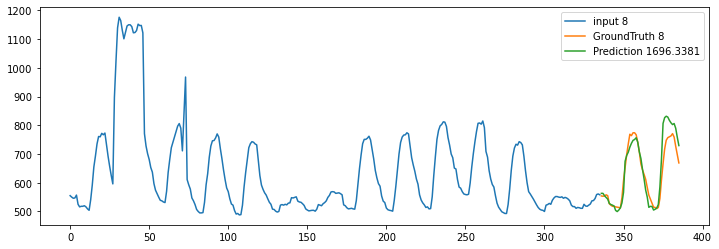

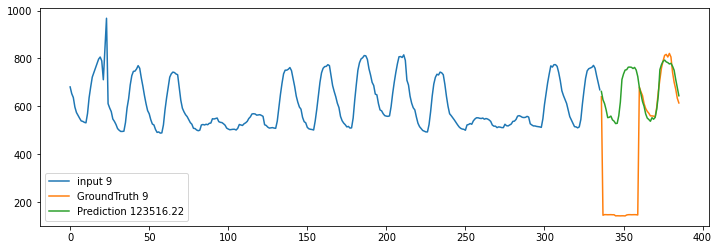

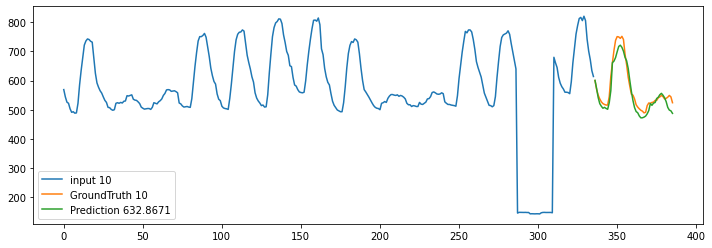

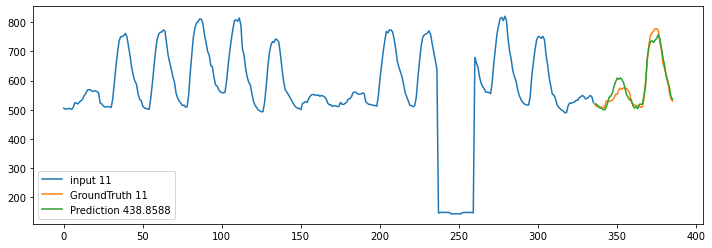

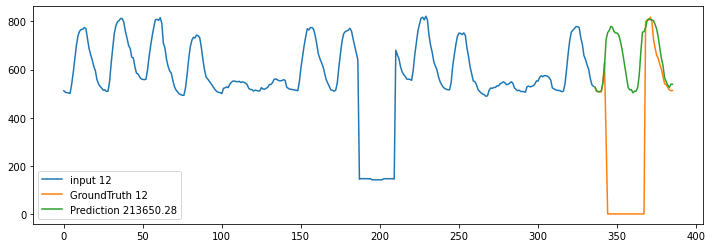

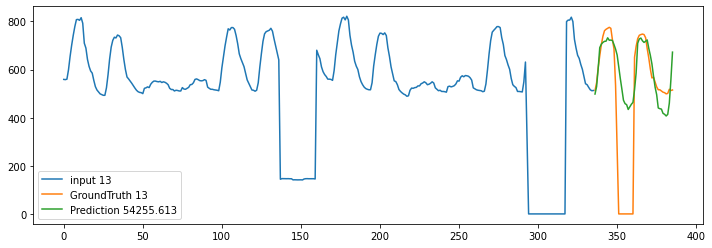

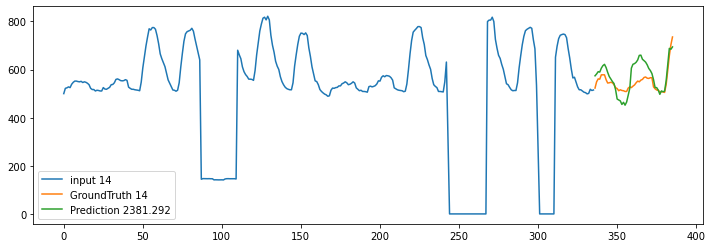

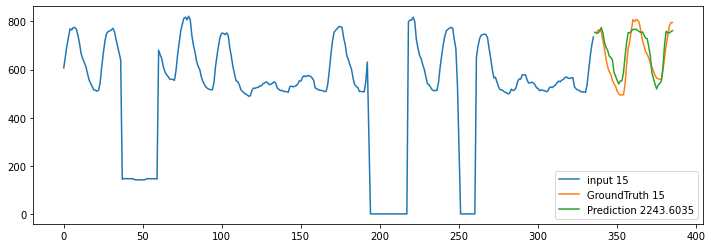

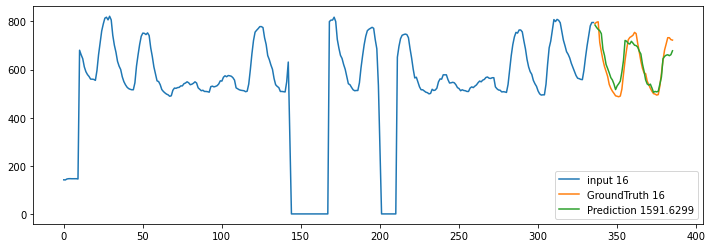

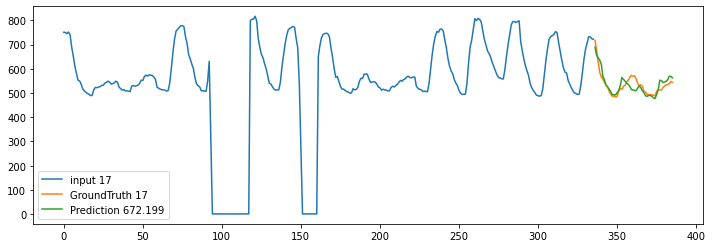

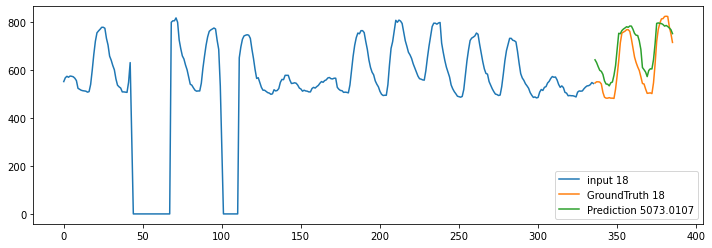

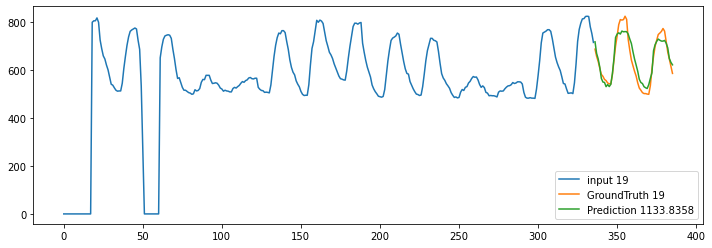

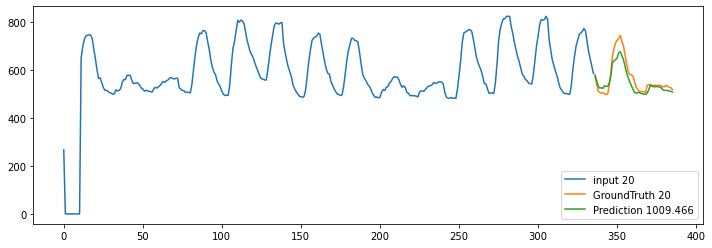

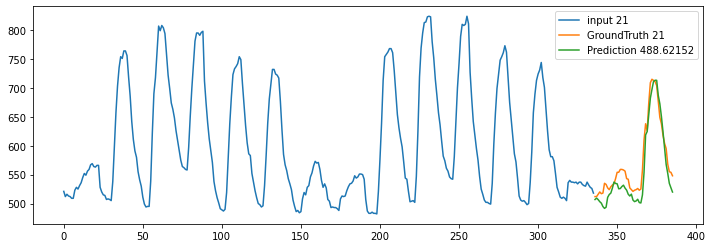

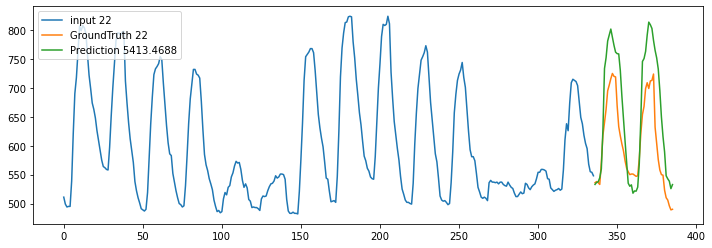

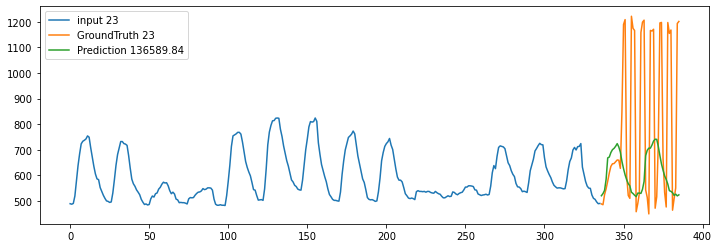

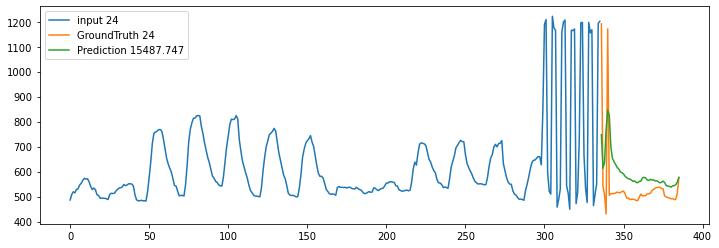

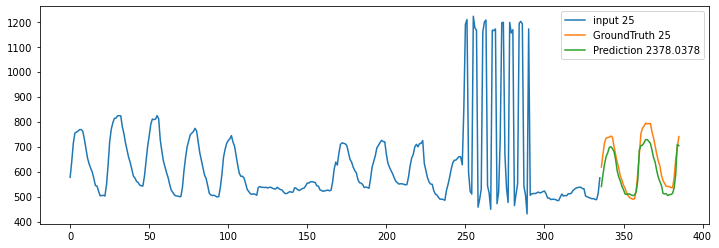

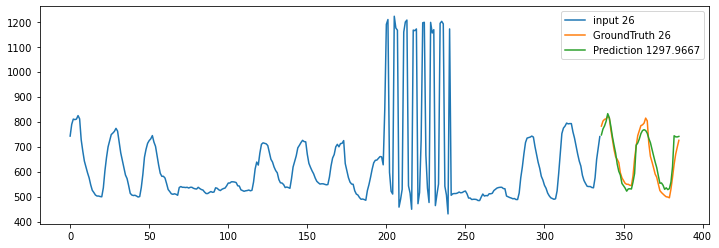

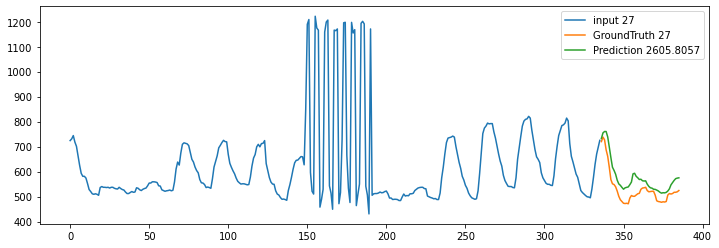

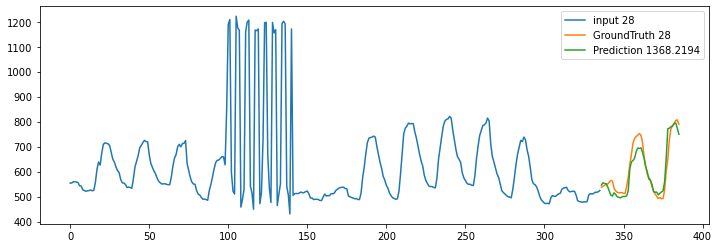

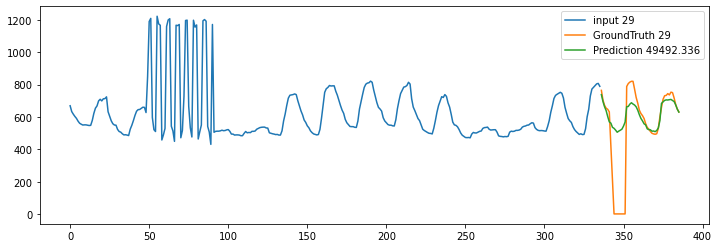

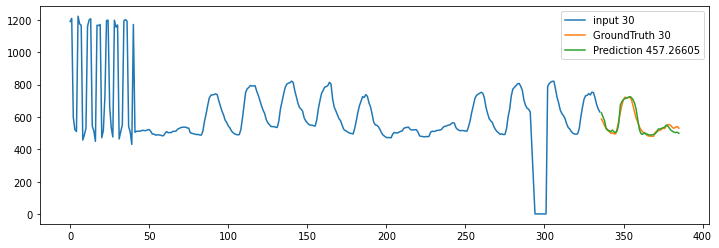

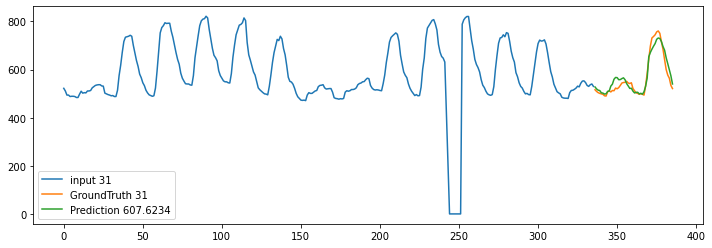

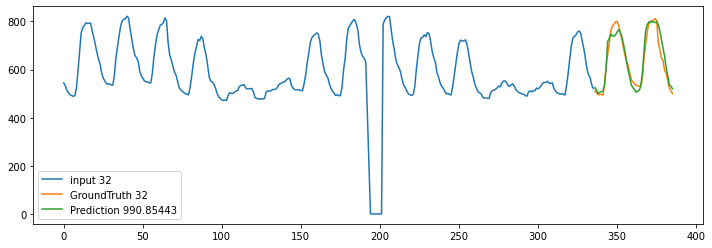

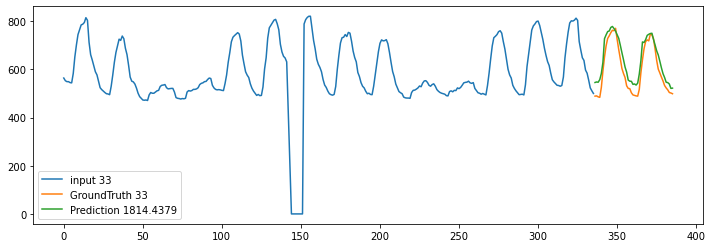

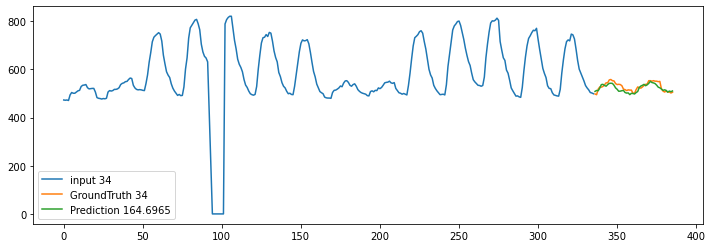

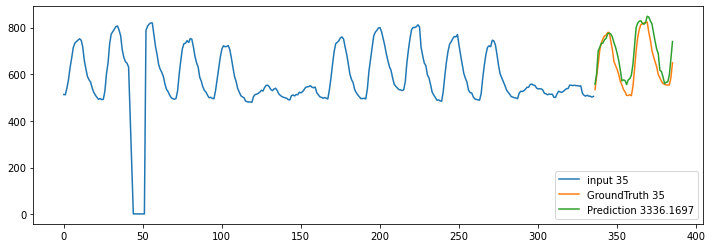

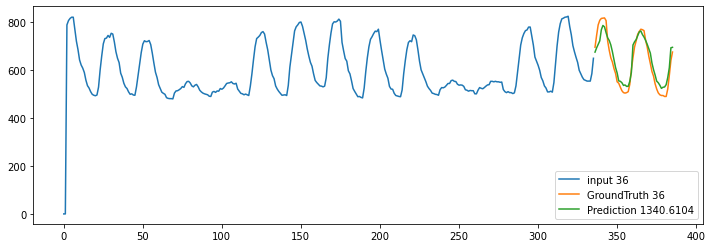

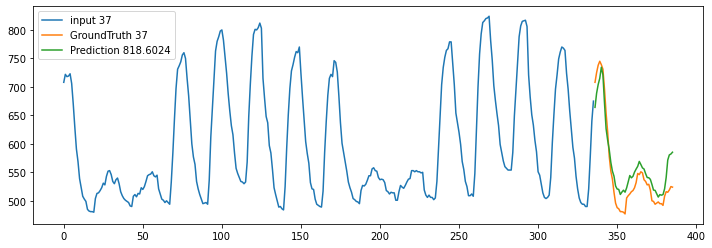

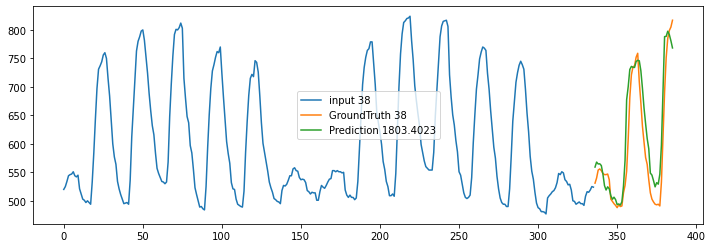

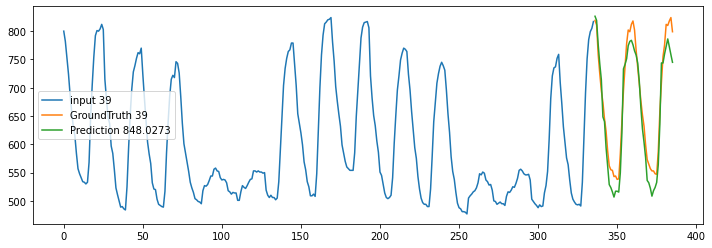

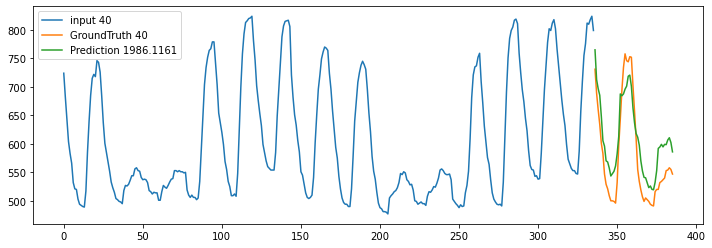

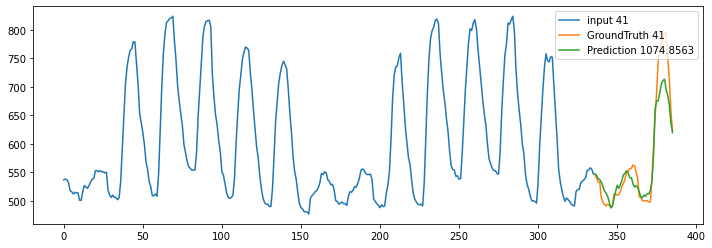

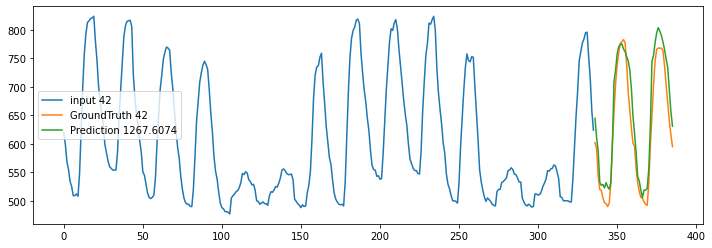

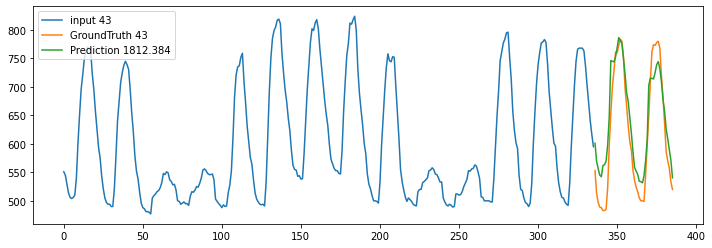

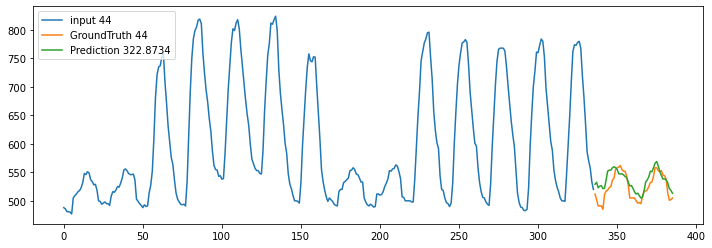

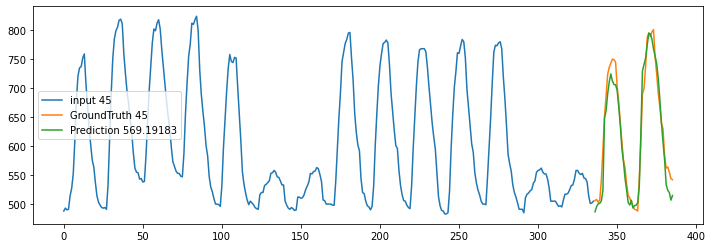

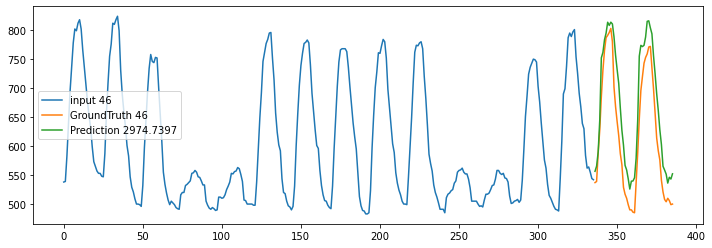

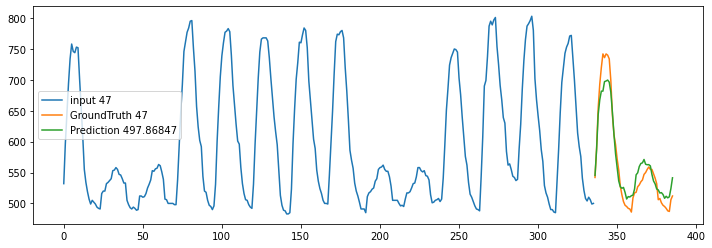

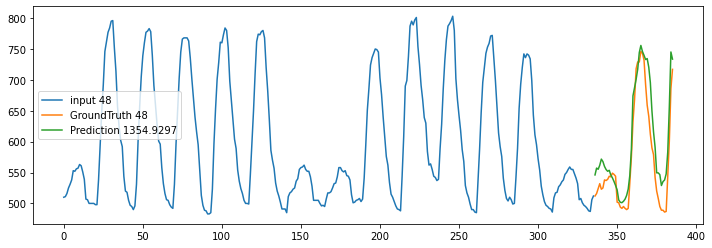

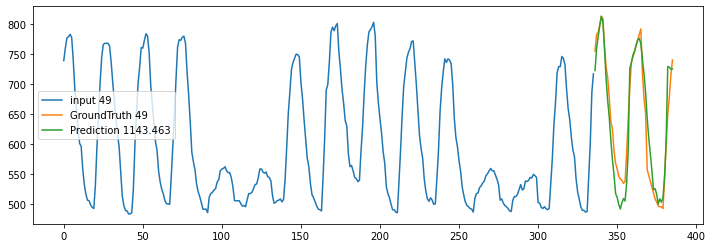

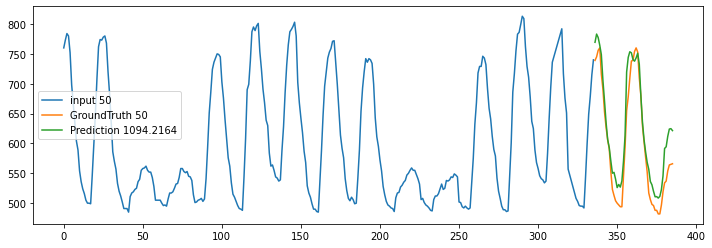

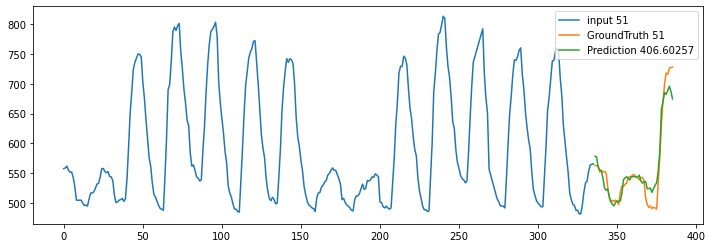

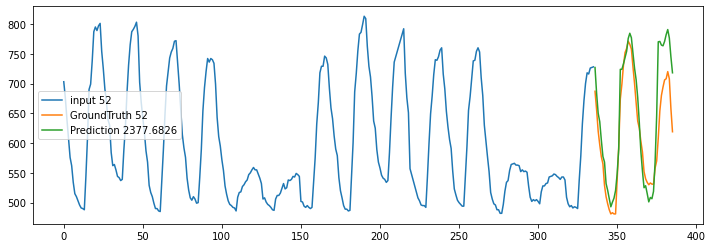

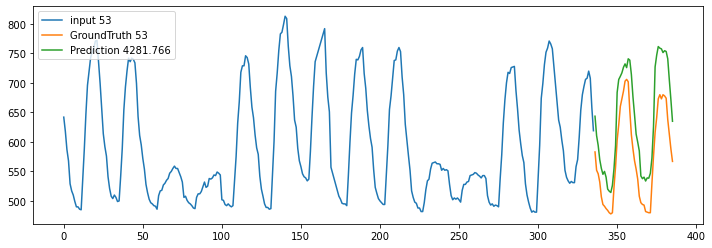

In [12]:
plt.rcParams['figure.figsize'] = (12,4)
x = np.arange(inputs.shape[1]+preds.shape[1])
a = inputs.shape[1]

for i in range(54):
    plt.figure()
    c =i 
    plt.plot(x[:a],inputs[c],label='input '+str(c))
    plt.plot(x[a:],trues[c,:,0], label='GroundTruth '+str(c))
    #for i in range(1):

    plt.plot(x[a:],preds[c,:,0], label='Prediction '+str(mean_squared_error(preds[c,:,0],trues[c,:,0])))
    
    plt.legend()
    # fig = plt.figure()
    # plt.savefig("images/trans-mse_test_"+str(i)+".png")
    
    # plt.show()

In [13]:
!python mask_generator.py --dataset_name energy

(323, 25) (323, 25) 323 323 54
Best Threshold: 0.09240700304508209 with G-Mean: 0.94551
FPR: 0.016611, TPR: 0.909091
(161, 50) (161, 50) 161 161 27
Best Threshold: 0.05227600038051605 with G-Mean: 0.954684
FPR: 0.034965, TPR: 0.944444
(8075,) (8050,) (8766, 1)
(8050,)
File saved as /mnt/cat/data/sandy/Forecasting/data/energy/energy_mask_roc.npy !!
energy_mask_roc.npy                           100%   32KB 657.0KB/s   00:00    
File saved as sandy@dog.cse.iitb.ac.in:/mnt/a99/d0/sandy/Forecasting/data/energy/energy_mask_roc.npy !!


In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import iqr
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.metrics import roc_curve, auc
from sklearn.datasets import make_classification
from sklearn import metrics, datasets
DATA_DIRS = "/mnt/a99/d0/sandy/Forecasting/"
df = pd.read_csv(
    os.path.join(DATA_DIRS, 'data', 'electricity_load_forecasting_panama', '2_percent_electricity.csv')
)
data = df[['nat_demand']].to_numpy().T
labels =  df[['label']].to_numpy()

path = "Results/electricity_train_m/electricity_ip_100_op_50_test_01/electricity/"
preds = np.load(path+'trans-mse-ar_pred_mu.npy')
inputs = np.load(path+'inputs.npy')
trues = np.load(path+'targets.npy')
new_preds = preds.squeeze()
new_trues = trues.squeeze()
N_input = 336
# print(new_preds.shape,new_trues.shape)
n = (N_input-1)//50 + 1
(l,h) = new_preds.shape
final = []
for line in range(0,l,n-1):
    chunk = dict()
    chunk['preds'] = new_preds[line:line+n]
    chunk['trues'] = new_trues[line:line+n]
    chunk['mask'] = np.zeros_like(new_trues[line:line+n])
    chunk['mse'] = [(mean_squared_error(i,j)-minmse)/(maxmse-minmse) for i,j in zip(new_preds[line:line+n],new_trues[line:line+n])]
    final.append(chunk)
mse = [mean_squared_error(i,j) for i,j in zip(new_preds,new_trues)]

minmse = min(mse)
maxmse = max(mse)
mse_norm = [(m-minmse)/(maxmse-minmse) for m in mse]


labels = labels[200:200+l*h].reshape(-1,h)


last = 3
if h==25:
    last = 3

label = [1 if sum(line)>5 else 0 for line in labels]

fpr, tpr, thresholds = roc_curve(label, mse_norm)
score = metrics.auc(fpr, tpr)
print(labels.shape,new_preds.shape,len(label),len(mse))
print(thresholds)
# Calculate the G-mean
gmean = np.sqrt(tpr * (1 - fpr))
# Find the optimal threshold
index = np.argmax(gmean)
thresholdOpt = round(thresholds[index], ndigits = 6)
gmeanOpt = round(gmean[index], ndigits = 6)
fprOpt = round(fpr[index], ndigits = 6)
tprOpt = round(tpr[index], ndigits = 6)
print('Best Threshold: {} with G-Mean: {}'.format(thresholdOpt, gmeanOpt))
print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))

pred_labels = [1 if i>thresholdOpt else 0 for i in mse_norm ]

plt.plot(fpr,tpr)
plt.plot(fprOpt,tprOpt,marker="o")
plt.show()

# plt.plot(label)
plt.plot(np.array(label)-np.array(pred_labels))
plt.show()
final_mask = []
for i in pred_labels:
    temp = np.zeros((h))
    temp = temp + i
    # print(temp.shape)
    final_mask.extend(temp)
final_mask = np.array(final_mask)
for j,line in enumerate(final):
    # print(sorted(line['mse'],reverse=True))
    # msep = np.quantile(mse,0.75)+iqr(mse,interpolation='midpoint')*1.5
    for x in range(1,last):
        if len(line['mse'])<2:
            continue
        i = np.argsort(line['mse'])[-x]
        if line['mse'][i]>thresholdOpt:
            final[j]['mask'][i]= 1
mask = final[0]['mask'].flatten()
for line in final[1:]:
    mask=np.hstack((mask,line['mask'][1:].flatten()))


np.save("mask_electricity_100_op_50_1.npy",mask)

In [7]:
# print(len(mask))



In [133]:
mask1 = np.load("mask_electricity_100_op_25.npy")
mask2 = np.load("mask_electricity_100_op_50.npy")
mask3 = np.load("mask_electricity_100_op_25_1.npy")
mask4 = np.load("mask_electricity_100_op_50_1.npy")
m = trues.reshape(-1,)
print(mask1.shape,mask2.shape,m.shape)
# print(sum(mask)/len(mask))
# data_mask = mask1[25:-25]*mask2
length = min(len(mask1),len(mask2))
print(length)
mask1 = mask1[:length]
mask2 = mask2[:length]
mask3 = mask3[:length]
mask4 = mask4[:length]


(45475,) (45450,) (45450,)
45450


In [ ]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(
    go.Scatter(y= m,name='input'))
fig.add_trace(
    go.Scatter(y = mask1*500,name='mask25'))

fig.add_trace(
    go.Scatter(y = mask2*600,name='mask50'))
fig.add_trace(
    go.Scatter(y = mask3*700,name='mask25__1'))

fig.add_trace(
    go.Scatter(y = mask4*800,name='mask50__1'))



fig.show()


code for imputation

In [2]:
import numpy as np
import pandas as pd
import os
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import iqr
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.metrics import roc_curve, auc
from sklearn.datasets import make_classification
from sklearn import metrics, datasets
DATA_DIRS = "/mnt/a99/d0/sandy/Forecasting/"
df = pd.read_csv(
    os.path.join(DATA_DIRS, 'data', 'electricity_load_forecasting_panama', '2_percent_electricity.csv')
)
data = df[['nat_demand']].to_numpy()
labels =  df[['label']].to_numpy()
# print(sum(labels))
path = "Results/electricity_train_m/electricity_ip_100_op_50_test_01/electricity/"
preds = np.load(path+'trans-mse-ar_pred_mu.npy')
inputs = np.load(path+'inputs.npy')
trues = np.load(path+'targets.npy')
preds = preds.reshape(-1,)
trues = trues.reshape(-1,)
# print(preds.shape,inputs.shape,trues.shape)
cwd = "/mnt/cat/data/sandy/Forecasting/data/"
save_path=os.path.join(cwd,"electricity","electricity_mask_roc.npy")
mask_values = np.load(save_path)
# print(mask_values.shape,data.shape,labels.shape)
for i,x in enumerate(mask_values):
    if x==1:
        data[i+200]=preds[i]
        labels[i+200]=1
        # print(data[i+200])
df[['nat_demand']] = data
df[['label']] = labels

In [4]:
import subprocess
file_p =  os.path.join(cwd, 'electricity_load_forecasting_panama', 'electricity_imputation_iqr.csv')
file_ssh =  os.path.join(DATA_DIRS, 'data', 'electricity_load_forecasting_panama', 'electricity_imputation_iqr.csv')
df.to_csv(file_p)
subprocess.run(["scp",file_p, f"sandy@dog.cse.iitb.ac.in:{file_ssh}"])




CompletedProcess(args=['scp', '/mnt/cat/data/sandy/Forecasting/data/electricity_load_forecasting_panama/electricity_imputation_iqr.csv', 'sandy@dog.cse.iitb.ac.in:/mnt/a99/d0/sandy/Forecasting/data/electricity_load_forecasting_panama/electricity_imputation_iqr.csv'], returncode=0)